<a href="https://colab.research.google.com/github/FranciscoAguiar/DataScienceProgramming/blob/master/ProcessingTwitters_UEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise das mensagens trocadas por usuários do Twitter sobre a COVID-19


**Disciplina**: Programação para Ciência de Dados  
**Autores**: Francisco de Assis Marinho Aguiar e Leandro da Cruz Farias     
**Github:** https://github.com/FranciscoAguiar/DataScienceProgramming   
**Fonte de dados:** http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz

## Download do conjunto de dados

In [32]:
!wget http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz
!tar -xvf dados-curso-completo.csv.tar.gz

--2020-10-09 04:41:19--  http://tiagodemelo.info/datasets/dados-curso-completo.csv.tar.gz
Resolving tiagodemelo.info (tiagodemelo.info)... 108.167.188.189
Connecting to tiagodemelo.info (tiagodemelo.info)|108.167.188.189|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143340808 (137M) [application/x-gzip]
Saving to: ‘dados-curso-completo.csv.tar.gz.2’

dados-curso-complet 100%[===================>] 136.70M  23.6MB/s    in 6.7s    

2020-10-09 04:41:26 (20.4 MB/s) - ‘dados-curso-completo.csv.tar.gz.2’ saved [143340808/143340808]

dados-curso-completo.csv


## Instalação de bibliotecas

In [33]:
!pip install geopandas
!pip install wordcloud

## Importação das bibliotecas

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import nltk
import datetime

from shapely.geometry import Point
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option('display.max_colwidth', None)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Análise dos dados

In [35]:
tweets_df = pd.read_csv('dados-curso-completo.csv')
tweets_df.head()

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congresso está sentado em 3BI olhando a pandemia da janela.,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspendeu as aulas da rede estadual até 31 de março. ⁣\n⁣\nEsta ação está ali… https://t.co/EPFXOMtwSY",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanciamento social fazem parecer que as pessoas com alguma doença pré-exis… https://t.co/oEyXDF9cDy,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? https://t.co/JT1oMiUCXf,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
4,2020-03-19 17:49:40,Nova Impressão,novaimpressao_,🚨Todos juntos contra COVID-19💪\n\nSolicite seu material por e-mail ou WhatsApp. Caso venha até a empresa traga seu ma… https://t.co/p6wcoomynZ,0,124,pt,Brasília,Brazil,BR,-47.8778,-15.77691,[]


Total de registros:

In [36]:
len(tweets_df.index)

1658825

In [66]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658825 entries, 0 to 1658824
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   data        1658825 non-null  datetime64[ns]
 1   usuario     1658768 non-null  object        
 2   apelido     1658825 non-null  object        
 3   texto       1658825 non-null  object        
 4   retweet     1658825 non-null  int64         
 5   seguidores  1658825 non-null  int64         
 6   idioma      1658825 non-null  object        
 7   lugar       74605 non-null    object        
 8   pais        74600 non-null    object        
 9   sigla       74595 non-null    object        
 10  latitude    8720 non-null     float64       
 11  longitude   8720 non-null     float64       
 12  hashtags    1658825 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 164.5+ MB


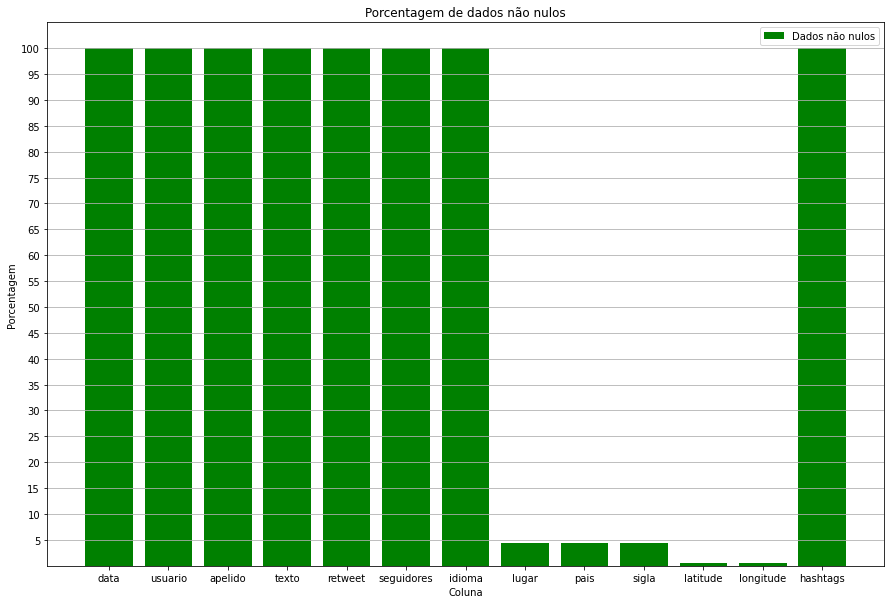

In [38]:
y = []
for label, column in tweets_df.items():
  y.append(column.notnull().mean() * 100)

plt.subplots(figsize=(15, 10))
plt.bar(tweets_df.columns, y, label="Dados não nulos", color='g')
plt.yticks(np.arange(5, max(y) + 1, 5))
plt.legend()
plt.grid(axis='y')
plt.xlabel('Coluna')
plt.ylabel('Porcentagem')
plt.title('Porcentagem de dados não nulos')
plt.show()

### Quantidade de tweets por idioma

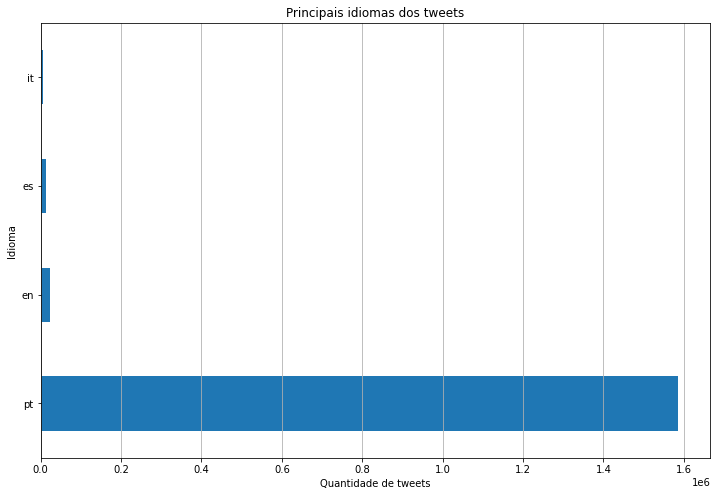

In [39]:
tweets_df.groupby('idioma').idioma.count().nlargest(4).plot(kind='barh', figsize=(12, 8))
plt.title('Principais idiomas dos tweets')
plt.xlabel('Quantidade de tweets')
plt.ylabel('Idioma')
plt.grid(axis='x')
plt.show()

### Quantidade de tweets por país

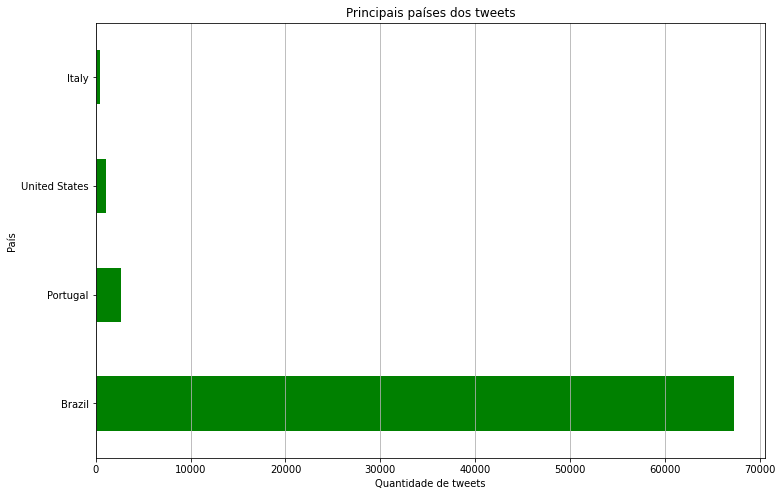

In [81]:
tweets_df.groupby('pais').pais.count().nlargest(4).plot(kind='barh', figsize=(12, 8), color='g')
plt.title('Principais países dos tweets')
plt.xlabel('Quantidade de tweets')
plt.ylabel('País')
plt.grid(axis='x')
plt.show()

### Quantidade de tweets por mês no primeiro semestre de 2020

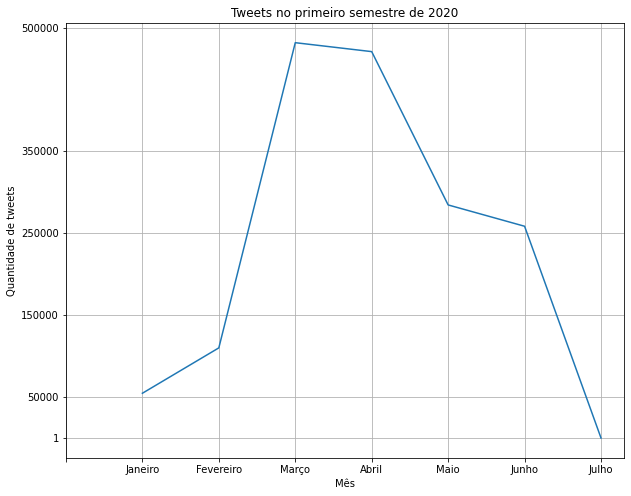

In [131]:
tweets_df.data = pd.to_datetime(tweets_df.data)
tweets_df.groupby(tweets_df.data.dt.month).texto.count().plot(figsize=(10, 8), yticks=[1, 50000, 150000, 250000, 350000, 500000])
plt.title('Tweets no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de tweets')
plt.xticks(ticks=np.arange(8), labels=[None, 'Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho'])
plt.grid()
plt.show()

### Tweets pelo mundo

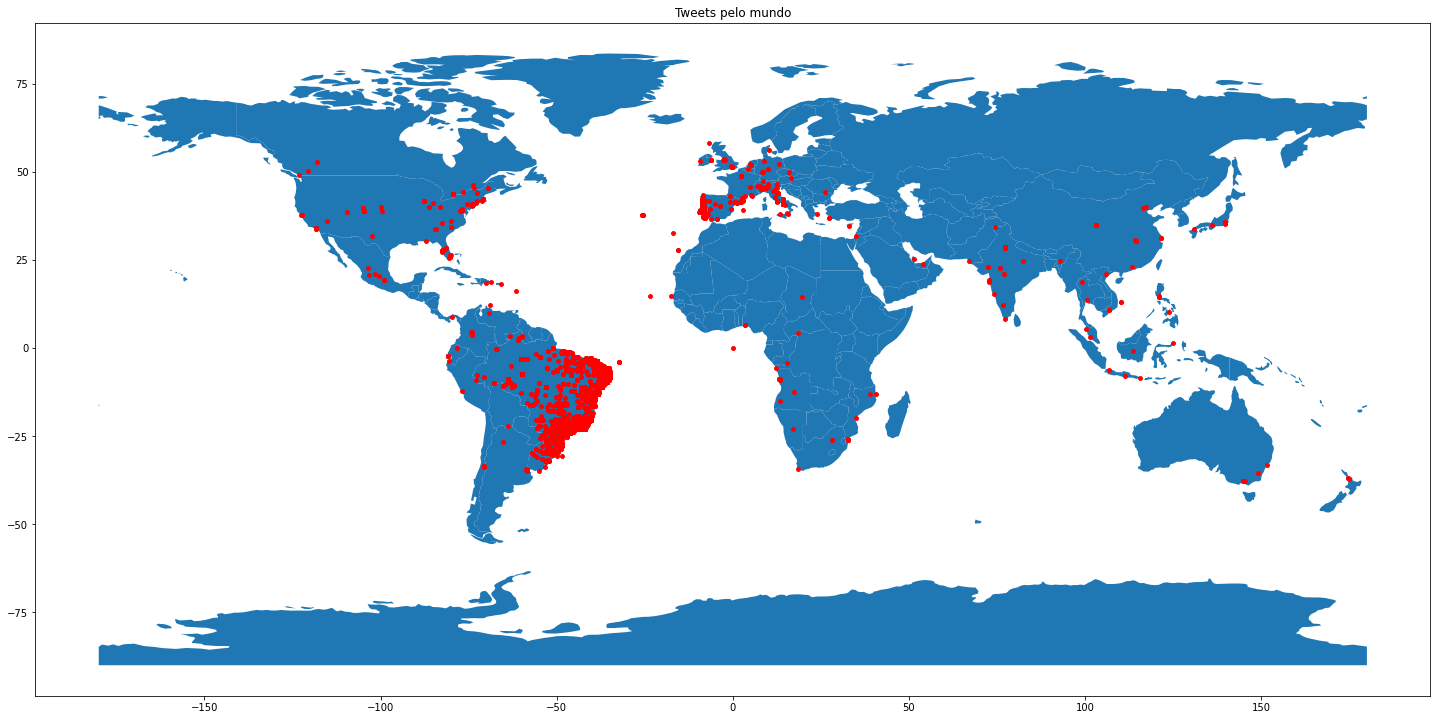

In [132]:
world_tweets_df = tweets_df.loc[tweets_df.latitude.notnull() & tweets_df.longitude.notnull()]
geometry = [Point(xy) for xy in zip(world_tweets_df.latitude, world_tweets_df.longitude)]
location_dic = {'tweet': world_tweets_df.texto, 'geometry': geometry}
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=world.plot(figsize=(25, 20)), marker='o', color='red', markersize=15)
plt.title('Tweets pelo mundo')
plt.show()

### Tweets pelo Brasil

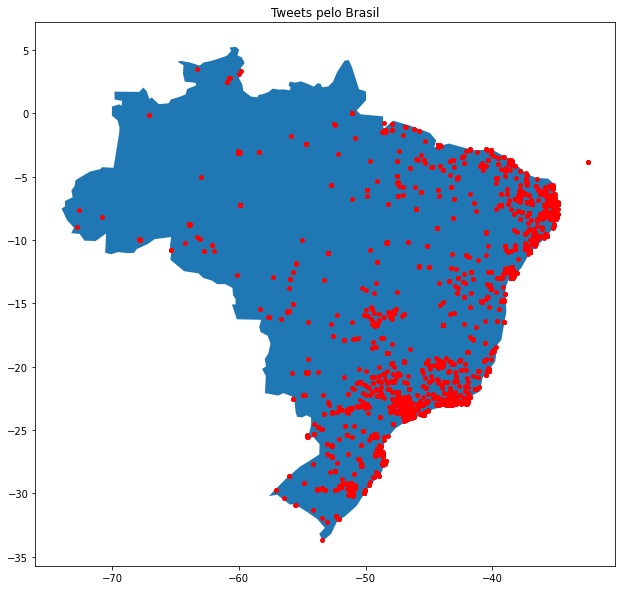

In [139]:
country = 'Brazil'
localized_tweets_df = tweets_df.loc[tweets_df.latitude.notnull() & tweets_df.longitude.notnull() & tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Tweets pelo Brasil')
plt.show()

## Perguntas no Twitter

In [44]:
questions_df = tweets_df.loc[tweets_df.texto.str.contains('?', regex=False)]
new_rows = []

for row in questions_df.itertuples():
  sentences = nltk.sent_tokenize(row.texto)

  for sentence in sentences:
    if '?' in sentence and len(sentence) > 2:
      new_rows.append((row.data, row.usuario, row.apelido, sentence, row.retweet, row.seguidores, row.idioma, row.lugar, row.pais, row.sigla, row.latitude, row.longitude, row.hashtags))

questions_df = pd.DataFrame(new_rows, columns=tweets_df.columns.array)
questions_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado???,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus?,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-06-25 11:09:19,Andreia Peraro,AndreiaPeraro,@ipratesMD @dr_pampers Será que corremos o risco de termos piolhos super resistentes?,0,86,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-06 15:44:36,Diorgenes Pandini,diorpandini,Prioridade ?!,0,219,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'floripa', 'isolamento']"
4,2020-03-30 00:43:36,Valnei do Val,vdoval,"Que tal uma notícia boa, indo na contramão do que a mídia corrupta está fazendo (tocando o terror na população)?",0,201,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198080,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Ansiedade?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198081,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Angústia?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198082,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Covid?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198083,2020-03-13 17:26:18,broca,whoisdrill,oms: tamo tendo pandemia evitar\n conglomerados\n\nunis*l: que tal uma aula no juri???,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]


In [45]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198085 entries, 0 to 198084
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   data        198085 non-null  datetime64[ns]
 1   usuario     198078 non-null  object        
 2   apelido     198085 non-null  object        
 3   texto       198085 non-null  object        
 4   retweet     198085 non-null  int64         
 5   seguidores  198085 non-null  int64         
 6   idioma      198085 non-null  object        
 7   lugar       8935 non-null    object        
 8   pais        8935 non-null    object        
 9   sigla       8935 non-null    object        
 10  latitude    661 non-null     float64       
 11  longitude   661 non-null     float64       
 12  hashtags    198085 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 19.6+ MB


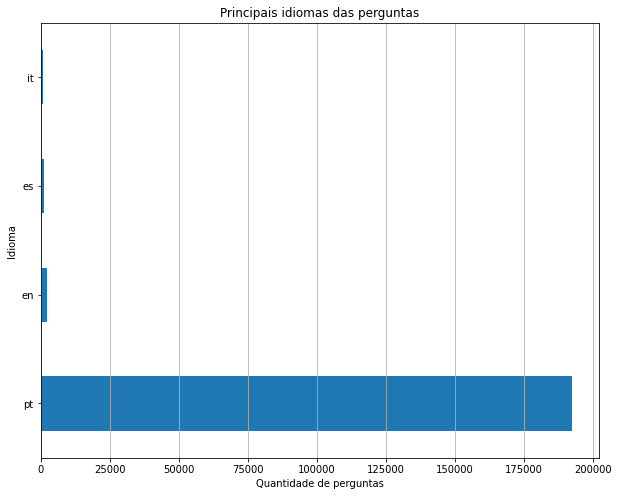

In [46]:
questions_df.groupby('idioma').idioma.count().nlargest(4).plot(kind='barh', figsize=(10, 8))
plt.title('Principais idiomas das perguntas')
plt.xlabel('Quantidade de perguntas')
plt.ylabel('Idioma')
plt.grid(axis='x')
plt.show()

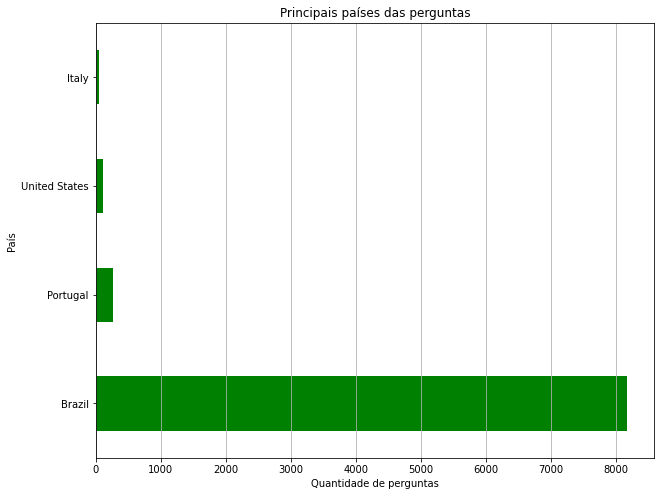

In [47]:
questions_df.groupby('pais').pais.count().nlargest(4).plot(kind='barh', figsize=(10, 8), color ='g')
plt.title('Principais países das perguntas')
plt.xlabel('Quantidade de perguntas')
plt.ylabel('País')
plt.grid(axis='x')
plt.show()

### Perguntas por mês
O gráfico abaixo mostra a quantidade de perguntas a partir de janeiro até junho.

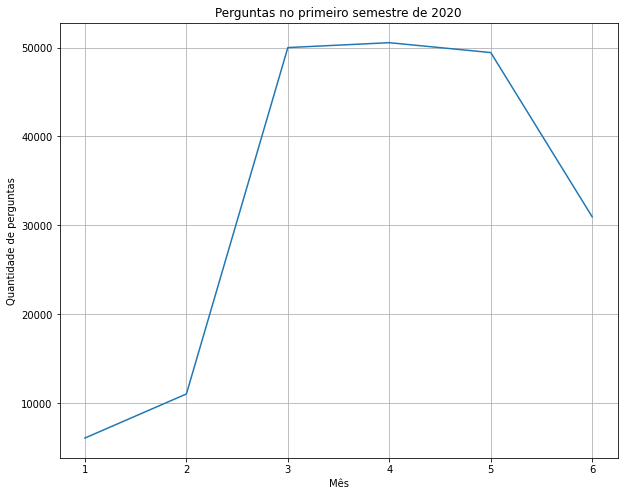

In [74]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(figsize = (10, 8))
plt.title('Perguntas no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.grid()
plt.show()

Houve aumento considerável no número de perguntas a partir do mês de fevereiro até o mês de março. A partir de então, o número de perguntas se manteu próximo a 50000 até o mês de maio, onde iniciou uma queda nas perguntas.

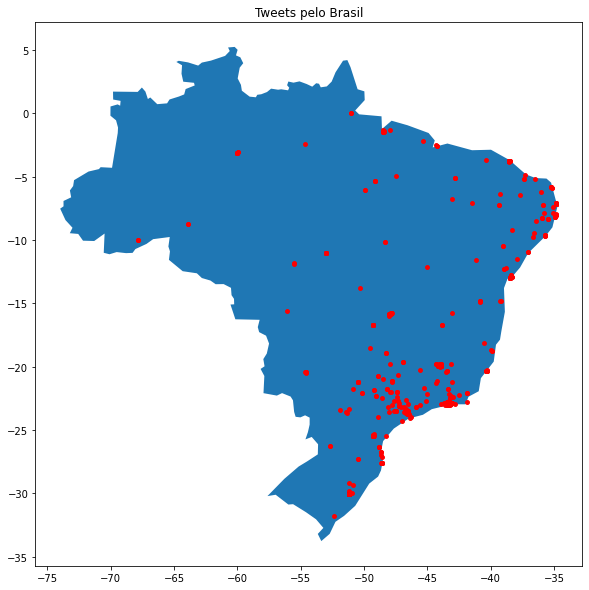

In [49]:
country = 'Brazil'
localized_tweets_df = questions_df.loc[questions_df.latitude.notnull() & questions_df.longitude.notnull() & questions_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Tweets pelo Brasil')
plt.show()

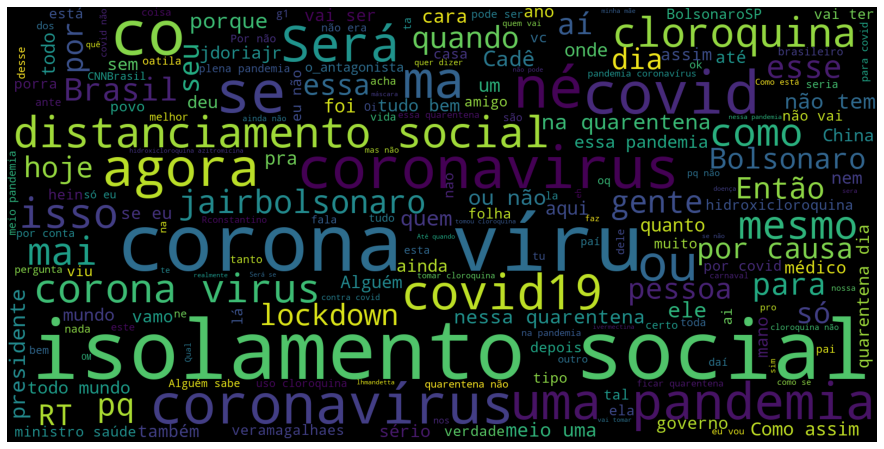

In [50]:
stopwords = set(STOPWORDS)
stopwords.update(["da", "meu", "em", "você", "de", "ao", "os","http","https","que"])
all_tweets = " ".join(s for s in questions_df.texto)
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=1600, height=800).generate(all_tweets)

fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
plt.show()

### Temas Discutidos
### Doença

In [51]:
is_disease = questions_df.texto.str.contains('covid|corona|vírus|virus|doença|doenca|pandemia|gripe|pneumonia|sintoma|comorbidade|quarentena', na=False, case=False)
disease_tweets_df = questions_df.loc[is_disease]
disease_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
1,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus?,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
5,2020-04-07 23:19:44,Mauricio Ligabo,LigaboMauricio,@JoseMedeirosMT Seria isso algum tipo aleatório de demência provocando pelo coronavírus?,0,23,pt,NaN,NaN,NaN,NaN,NaN,[]
6,2020-04-13 19:16:51,Gus,arrombagus,"""Nova York é o novo epicentro da pandemia de corona vírus""\n\nTa agora eu lhe pergunto cadê os vingadores?",3,253,pt,Santos,Brazil,BR,NaN,NaN,[]
9,2020-04-02 13:04:55,Luizcarlosdospatetas@hotmail.com,Luizcarlosdosp5,#perguntacorona \nQuero saber se a covid tem cura?,0,0,pt,NaN,NaN,NaN,NaN,NaN,['perguntacorona']
11,2020-04-02 13:56:41,Cândido Henrique,candidoh,"E essa chuvinha boa para pegar um resfriado e confundir com Covid-19, hem?",0,3254,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198075,2020-02-07 07:04:03,PT®️,ultratmr,@acruz39 Andas a fazer tratamentos ao Coronavirus?,0,977,pt,NaN,NaN,NaN,NaN,NaN,[]
198076,2020-03-24 23:50:14,solineuza da diarista,gtstayhigh,E ai quem são vcs durante a quarentena?,0,1329,pt,NaN,NaN,NaN,NaN,NaN,[]
198082,2020-05-25 22:53:13,O que houve com a couve?,couveluiza,Covid?,0,1883,pt,NaN,NaN,NaN,NaN,NaN,[]
198083,2020-03-13 17:26:18,broca,whoisdrill,oms: tamo tendo pandemia evitar\n conglomerados\n\nunis*l: que tal uma aula no juri???,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]


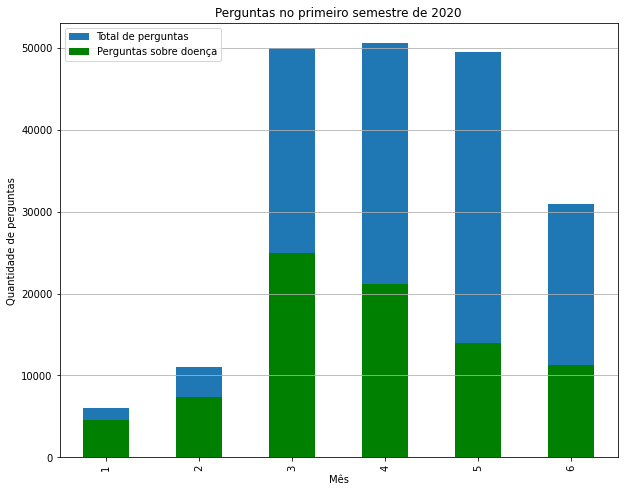

In [52]:
questions_df.groupby(questions_df.data.dt.month).texto.count().plot(kind='bar', figsize = (10, 8), label='Total de perguntas')
disease_tweets_df.groupby(disease_tweets_df.data.dt.month).texto.count().plot(kind="bar", figsize = (10, 8), color='g', label='Perguntas sobre doença')
plt.title('Perguntas no primeiro semestre de 2020')
plt.xlabel('Mês')
plt.ylabel('Quantidade de perguntas')
plt.legend()
plt.grid(axis='y')
plt.show()

A pergunta mais retweetada mencionou o coronavírus, mas serviu como base para uma cantada!


In [53]:
disease_tweets_df.loc[disease_tweets_df.retweet.eq(disease_tweets_df.retweet.max())]

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
76211,2020-03-22 03:43:41,jayne,jaynebullock14,RT @sineadxia: So shortness of breath is a corona symptom right but you know what also gives me shortness of breath?,107908,151,en,NaN,NaN,NaN,NaN,NaN,[]


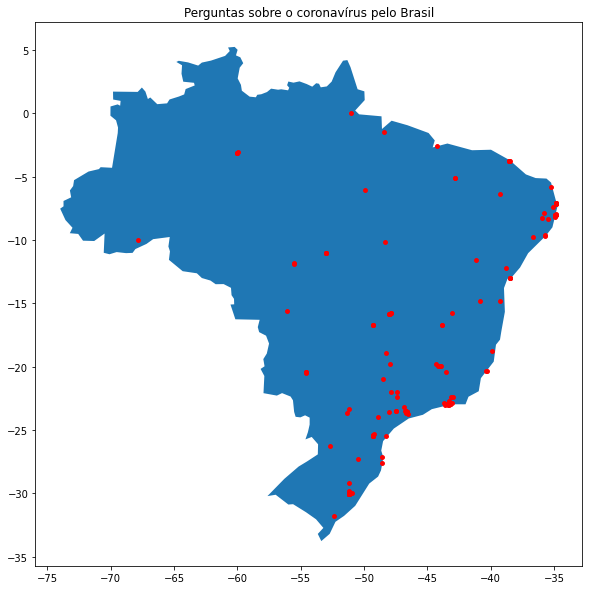

In [54]:
country = 'Brazil'
localized_tweets_df = disease_tweets_df.loc[disease_tweets_df.latitude.notnull() & disease_tweets_df.longitude.notnull() & disease_tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Perguntas sobre o coronavírus pelo Brasil')
plt.show()

### Medicamento

In [55]:
is_medicine = questions_df.texto.str.contains('azitromicina|cloroquina|ivermectina|tamiflu|hidroxi|vacina', na=False, case=False)
medicine_tweets_df = questions_df.loc[is_medicine]
medicine_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
8,2020-04-08 22:04:51,lulleitao,lulleitao,"@JeanSCorrea7 Mas ele não deu a entender que o Tamiflu era melhor, neh?",0,2315,pt,NaN,NaN,NaN,NaN,NaN,[]
15,2020-03-30 19:22:45,Gisele Reis,GiseleReisSilva,@bbcbrasil @cavmota A pergunta que não quer calar: quem faz uso contínuo de hidroxicloroquina está imune ao vírus???,0,60,pt,NaN,NaN,NaN,NaN,NaN,[]
20,2020-06-04 15:02:36,Mira lo que tienes,NoDosOutros_,Problemas no paraíso da Cloroquina?,0,133,pt,NaN,NaN,NaN,NaN,NaN,[]
32,2020-03-28 14:05:59,Priscila Andrade Rodrigues,PriAndRodrigues,"@veramagalhaes VERBA 792K, FALE SOBRE A CLOROQUINA?",0,1777,pt,NaN,NaN,NaN,NaN,NaN,[]
48,2020-06-04 05:20:18,🇧🇷edivaldo1000🇧🇷,edivaldo1000,Será que a Renata vai tomar cloroquina William bonner?,2,49493,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198011,2020-03-25 20:21:46,Lais S Vello,la_vello,Ou está tratando hidroxicloroquina?,0,105,pt,NaN,NaN,NaN,NaN,NaN,[]
198012,2020-05-15 21:04:20,marquinhos tavares,marcoosvieira,QUAIS os países estão usando cloroquina para tratamento do corona?,0,566,pt,NaN,NaN,NaN,NaN,NaN,[]
198022,2020-05-23 12:54:53,Andrea Mansur,Andrea_Mansur,?estamos usando cloroquina… https://t.co/wnPrh5jFyY,0,1618,pt,NaN,NaN,NaN,NaN,NaN,[]
198036,2020-05-05 16:10:27,☮Cristina Leão,CristininhaLeao,"@octavio_guedes Sabe-se quantas pessoas infectadas pelo Covid 19 foram vacinadas contra gripe, nesse ano?",0,75,pt,Rio de Janeiro,Brazil,BR,NaN,NaN,[]


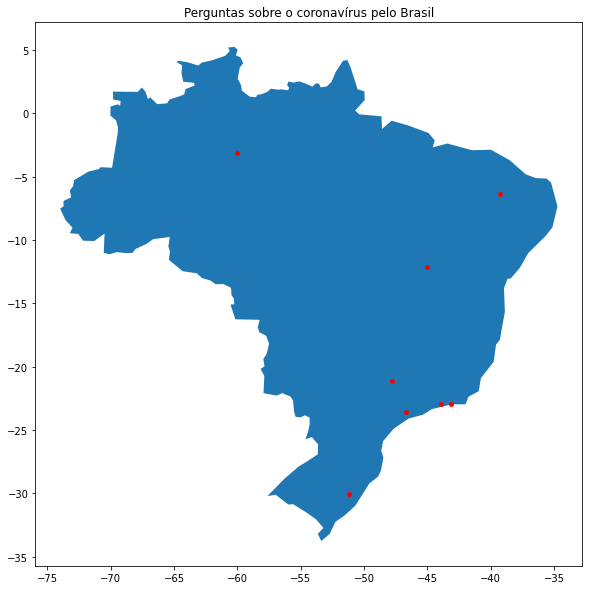

In [56]:
country = 'Brazil'
localized_tweets_df = medicine_tweets_df.loc[medicine_tweets_df.latitude.notnull() & medicine_tweets_df.longitude.notnull() & medicine_tweets_df.pais.eq(country)]
geometry = [Point(xy) for xy in zip(localized_tweets_df.latitude, localized_tweets_df.longitude)]
location_dic = {'tweet': localized_tweets_df.texto, 'geometry': geometry}
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).loc[world.name == country]

tweets_gdf = gpd.GeoDataFrame(location_dic, geometry=geometry)
tweets_gdf.plot(ax=brazil.plot(figsize=(15, 10)), marker='o', color='red', markersize=15)
plt.title('Perguntas sobre o coronavírus pelo Brasil')
plt.show()

### Organizações

In [57]:
are_organizations = questions_df.texto.str.contains('oms|ministério da saúde|ministerio da saude|globo|sbt|band|record|uol|g1|bbc|cnn', na=False, case=False)
organizations_tweets_df = questions_df.loc[are_organizations]
organizations_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
15,2020-03-30 19:22:45,Gisele Reis,GiseleReisSilva,@bbcbrasil @cavmota A pergunta que não quer calar: quem faz uso contínuo de hidroxicloroquina está imune ao vírus???,0,60,pt,NaN,NaN,NaN,NaN,NaN,[]
40,2020-03-11 20:00:34,Luis Rocha 🇧🇷 #ForaBolsonaro,Luis_mergulhado,Ops.... nossa bandeira mudou de cor????,0,1148,pt,NaN,NaN,NaN,NaN,NaN,"['Brasil', 'SEJOGA', 'TheCircleBrasil', 'ElaMeInspira']"
43,2020-02-17 23:01:59,#ETC 🏴,epictimechat,Coronavírus invadiu a vinheta do Jornal da Band?,3,7966,pt,NaN,NaN,NaN,NaN,NaN,[]
57,2020-04-08 21:14:58,PatriotRobot,PatriotRobot,"@CNNBrasil Só a Cloroquina já derruba os dois vírus, Ditadória deu dinheiro pra vocês?",0,663,pt,NaN,NaN,NaN,NaN,NaN,[]
80,2020-04-28 23:54:42,Gamarra Levy,LevyGamarra,Como o Ministério da Saúde administra a pandemia de coronavírus?,0,966,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197913,2020-05-10 18:41:44,Giuseppe Silva 🇵🇹🇮🇹,joseecarla9,@radiotupi NÃO seria culpa da GLOBO?!,0,163,pt,NaN,NaN,NaN,NaN,NaN,[]
197936,2020-05-14 12:52:06,Roberto Paixão,RobertoPaixo11,"#GrandeDebateCNN Tiago Anastácio, falou q faltou diálogo da parte do presidente, para o controle do covid?",0,16,pt,NaN,NaN,NaN,NaN,NaN,['GrandeDebateCNN']
198024,2020-01-29 18:37:44,Inês Santos 🚩em casa 🏡,mariasinha28,@ZugRS Mas a oms não tem um protocolo mundial de comportamento pra cada país?,0,339,pt,NaN,NaN,NaN,NaN,NaN,[]
198054,2020-05-31 16:23:36,❌ABORTO🚫DROGAS☠COMUNISMO,BolsonaroAte,@g1 E A QUARENTENA??,0,544,pt,NaN,NaN,NaN,NaN,NaN,[]


### Pessoas

In [58]:
are_people = questions_df.texto.str.contains('mandetta|ministro|jair|bolsonaro|depudato|presidente|juiz', na=False, case=False)
people_tweets_df = questions_df.loc[are_people]
people_tweets_df

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado???,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
7,2020-05-15 18:15:33,Silveacyr Maria Coelho Santos,silveacyr,@mitags Será por que o Bolsonaro não fez propaganda?,0,67,pt,NaN,NaN,NaN,NaN,NaN,[]
16,2020-03-18 17:15:18,why so serious?,ph_Dasein,Você iria na festa de aniversário de @jairbolsonaro ?,0,181,pt,NaN,NaN,NaN,NaN,NaN,"['COVID19', 'Covid_19', 'Bolsonaroacabou', 'panelaco18M']"
65,2020-03-24 23:40:18,eu que lute 🏳️‍🌈⃤,allisonanjos,É sério que o presidente mandou os governadores pararem com a quarentena?,1,1384,pt,NaN,NaN,NaN,NaN,NaN,[]
71,2020-04-15 19:59:04,Gabrielle,gabiiiaquiino,@jairbolsonaro \nComo vc demite uma pessoa que tá alertando pessoas sobre o perigo da quarentena?,0,483,pt,NaN,NaN,NaN,NaN,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197992,2020-03-12 19:04:32,Léo Araújo,leo_araujo2109,"@BolsonaroSP @fabiowoficial @conexaopolitica Ué, mas o Covid-19 não era uma fantasia?",0,8,pt,NaN,NaN,NaN,NaN,NaN,[]
197996,2020-06-01 16:12:55,Ana Paula 🌹🇧🇷🕊️,AdvDeus,Cadê o Ministro da Saúde???,2,227,pt,NaN,NaN,NaN,NaN,NaN,['coronavirus']
198009,2020-03-25 20:21:46,Lais S Vello,la_vello,@jairbolsonaro Você fez?,0,105,pt,NaN,NaN,NaN,NaN,NaN,[]
198025,2020-02-24 01:06:27,claudio,claudio29964592,@CarlosBolsonaro e daí ???,0,14,pt,NaN,NaN,NaN,NaN,NaN,[]


A pergunta mais retweetada foi:

In [59]:
people_tweets_df.loc[people_tweets_df.retweet.eq(people_tweets_df.retweet.max())]

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
114768,2020-05-15 18:20:50,Carolina Hartung,Carol_Hartc,RT @gugachacra: Quem aceitará ser ministro da Saúde?,10676,2877,pt,NaN,NaN,NaN,NaN,NaN,[]



**Visão Temporal - Por dia**



In [60]:
date = '2020-06-10'  #@param {type: "date"}
#@markdown ---
#date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

# run this line only first time
#questions_df['data'] = questions_df['data'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

date_time_str = date
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')
interval = (questions_df.data.dt.date == date_time_obj.date() ) 
df_interval = questions_df.loc[interval]
print("Total de perguntas no dia: " + date )
df_interval.shape



Total de perguntas no dia: 2020-06-10


(125, 13)

In [61]:
 print("Nuvem de palavras para o dia :"+ date)

Nuvem de palavras para o dia :2020-06-10


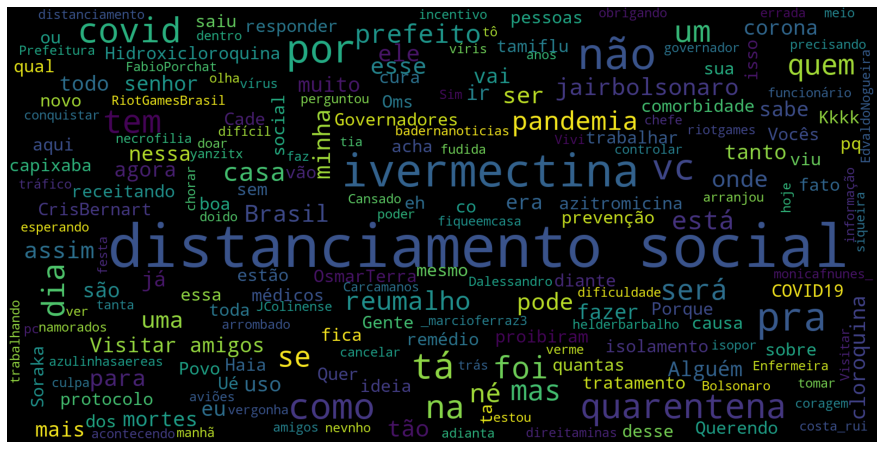

In [62]:
all_tweets = " ".join(s for s in df_interval.texto)
wordcloud = WordCloud(stopwords=stopwords, background_color='black', width=1600, height=800).generate(all_tweets)

fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
plt.show()

Número de perguntas por **horário**

237       22:48:55
3177      15:10:50
3178      15:10:50
6834      23:20:50
7630      17:32:06
            ...   
187375    23:59:33
187376    23:59:33
190611    11:14:49
191923    23:53:36
193536    23:59:28
Name: data, Length: 125, dtype: object


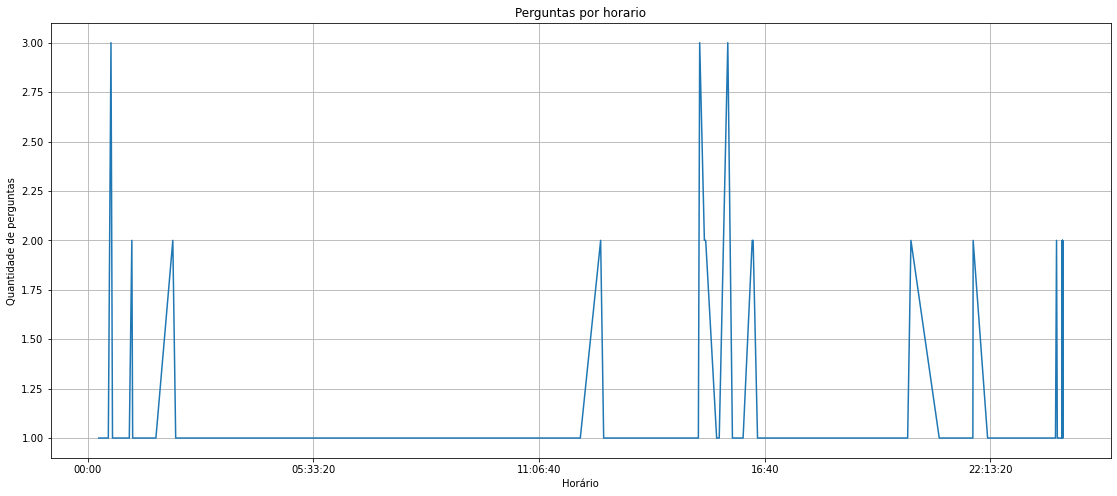

In [63]:
horarios = df_interval.data.dt.time
print(horarios)
grouped_df = df_interval.groupby(df_interval.data.dt.time).size()

grouped_df.plot(figsize = (19, 8))
plt.title('Perguntas por horario')
plt.xlabel('Horário')
plt.ylabel('Quantidade de perguntas')
plt.grid()
plt.show()
